## 과제 1
ReLu activation function과 derivative function을 구현해보세요
- Hint : np.maximum 함수 사용하면 편리합니다
- 다른 방법 사용하셔도 무방합니다


In [1]:
def relu(x):
    return np.maximum(0,x)

In [1]:
def d_relu(x):
    if x>0:
        d= 1
    elif x<0:
        d=0
    else:
        d = None
    return d

## 과제 2
Deep Learning Basic 코드 파일의 MLP implementation with Numpy library using MNIST dataset 코드 참고해서
Three layer MLP 일 때의 backward_pass 함수를 완성해주세요.   
- Hint : 코드 파일의 예시는 Two layer MLP


In [2]:
def backward_pass(x, y_true, params):

    dS3 = params["A3"] - y_true

    grads = {}

    grads['dW3'] = np.dot(dS3, params["A2"].T)/x.shape[1]
    grads['db3'] = (1/x.shape[1])*np.sum(dS3, axis=1, keepdims=True)/x.shape[1]
    
    dA2= np.dot(params["W3"].T, dS3)
    dS2= dA2 * d_sigmoid(params["S2"])
    
    grads["dW2"] =  np.dot(dS2, params["A1"].T)/x.shape[1]
    grads["db2"] =  (1/x.shape[1])*np.sum(dS2, axis=1, keepdims=True)/x.shape[1]

    dA1 = np.dot(params["W2"].T, dS2)
    dS1 = dA1 * d_sigmoid(params["S1"])

    grads["dW1"] = np.dot(dS1, x.T)/x.shape[1]
    grads["db1"] = np.sum(dS1, axis=1, keepdims=True)/x.shape[1]

    return grads

## 과제 3
Deep Learning Basic 코드 파일의 MLP implementation with Pytorch library using MNIST dataset 코드 참고해서
Three layer MLP를 구한후, 학습을 돌려 보세요

hyperparameter는 다음과 같이 설정

- epochs : 100
- hiddensize : 128, 64 (two layer)
- learning_rate : 0.5

In [ ]:
# Assignment 3 구현은 여기서 ()

In [3]:
from torchvision import transforms, datasets
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [5]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [6]:
trainset = datasets.MNIST(
    root      = './.data/', 
    train     = True,
    download  = True,
    transform = transform
)
testset = datasets.MNIST(
    root      = './.data/', 
    train     = False,
    download  = True,
    transform = transform
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./.data/MNIST/raw/train-images-idx3-ubyte.gz to ./.data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./.data/MNIST/raw/train-labels-idx1-ubyte.gz to ./.data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./.data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./.data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./.data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./.data/MNIST/raw



In [7]:
BATCH_SIZE = 512
train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
test_loader =  DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True)

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layer1 = nn.Linear(784,128)
        self.layer2 = nn.Linear(128,64)
        self.layer3 = nn.Linear(64,10)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = x.view(-1, 784)
        out = self.layer1(x)
        out = self.relu(out)
        out = self.layer2(out)
        out = self.relu(out)
        out = self.layer3(out)

        return out

In [9]:
model = Net()
model

Net(
  (layer1): Linear(in_features=784, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=64, bias=True)
  (layer3): Linear(in_features=64, out_features=10, bias=True)
  (relu): ReLU()
)

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.5)

In [11]:
def train(model, train_loader, optimizer):
    model.train()
    # 배치 당 loss 값을 담을 리스트 생성
    batch_losses = []

    for data, target in train_loader:
        # 옵티마이저의 기울기 초기화
        optimizer.zero_grad()

        # y pred 값 산출
        output = model(data)
        # loss 계산
        # 정답 데이터와의 cross entropy loss 계산
        # 이 loss를 배치 당 loss로 보관
        loss = criterion(output, target)
        batch_losses.append(loss)

        # 기울기 계산
        loss.backward()

        # 가중치 업데이트!
        optimizer.step()
        
    # 배치당 평균 loss 계산
    avg_loss = sum(batch_losses) / len(batch_losses)
    
    return avg_loss

In [12]:
def evaluate(model, test_loader):
    # 모델을 평가 모드로 전환
    model.eval()

    batch_losses = []
    correct = 0 

    with torch.no_grad(): 
        for data, target in test_loader:
            # 예측값 생성
            output = model(data)

            # loss 계산 (이전과 동일)
            loss = criterion(output, target)
            batch_losses.append(loss)

           # Accuracy 계산
           # y pred와 y가 일치하면 correct에 1을 더해주기
            pred = output.max(1, keepdim=True)[1]

            # eq() 함수는 값이 일치하면 1을, 아니면 0을 출력.
            correct += pred.eq(target.view_as(pred)).sum().item()

    # 배치 당 평균 loss 계산 
    avg_loss =  sum(batch_losses) / len(batch_losses)

    #정확도 계산
    accuracy = 100. * correct / len(test_loader.dataset)

    return avg_loss, accuracy

In [15]:
EPOCHS = 100
test_loss_lst=[]
for epoch in range(1, EPOCHS + 1):
    train_loss = train(model, train_loader, optimizer)
    test_loss, test_accuracy = evaluate(model, test_loader)
    
    print('[{}] Train Loss: {:.4f}\tTest Loss: {:.4f}\tAccuracy: {:.2f}%'.format(
          epoch, train_loss, test_loss, test_accuracy))
    test_loss_lst.append(test_loss)

[1] Train Loss: 0.0318	Test Loss: 0.1443	Accuracy: 96.38%
[2] Train Loss: 0.0316	Test Loss: 0.1580	Accuracy: 96.31%
[3] Train Loss: 0.0320	Test Loss: 0.1608	Accuracy: 96.14%
[4] Train Loss: 0.0306	Test Loss: 0.1503	Accuracy: 96.62%
[5] Train Loss: 0.0303	Test Loss: 0.1924	Accuracy: 95.63%
[6] Train Loss: 0.0302	Test Loss: 0.1723	Accuracy: 96.19%
[7] Train Loss: 0.0279	Test Loss: 0.1533	Accuracy: 96.52%
[8] Train Loss: 0.0271	Test Loss: 0.1593	Accuracy: 96.38%
[9] Train Loss: 0.0261	Test Loss: 0.1512	Accuracy: 96.55%
[10] Train Loss: 0.0251	Test Loss: 0.1618	Accuracy: 96.49%
[11] Train Loss: 0.0254	Test Loss: 0.1646	Accuracy: 96.31%
[12] Train Loss: 0.0253	Test Loss: 0.1570	Accuracy: 96.52%
[13] Train Loss: 0.0241	Test Loss: 0.1533	Accuracy: 96.50%
[14] Train Loss: 0.0217	Test Loss: 0.3655	Accuracy: 92.90%
[15] Train Loss: 1.1921	Test Loss: 0.3907	Accuracy: 88.37%
[16] Train Loss: 0.2624	Test Loss: 0.2576	Accuracy: 92.30%
[17] Train Loss: 0.1989	Test Loss: 0.2279	Accuracy: 93.09%
[18] T

## 과제 4
과제 3 부분의 성능을 지금까지 배운 지식을 바탕으로 향상시켜보세요

- Hint : Activation function, hyperparameter setting

In [14]:
# Assignment 4 구현은 여기서 ()

In [30]:
test_loss_lst[0].item()

0.14432890713214874

In [32]:
for index in range(0,len(test_loss_lst)):
  test_loss_lst[index] = test_loss_lst[index].item()

In [35]:
import matplotlib.pyplot as plt

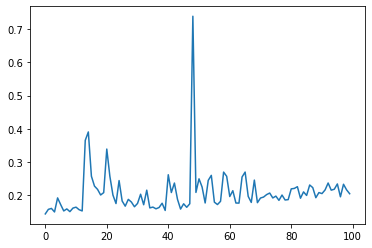

In [36]:
plt.plot(test_loss_lst)

In [42]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layer1 = nn.Linear(784,128)
        self.layer2 = nn.Linear(128,64)
        self.layer3 = nn.Linear(64,10)
        self.leaky_relu = nn.LeakyReLU(0.1)
        
    def forward(self, x):
        x = x.view(-1, 784)
        out = self.layer1(x)
        out = self.leaky_relu(out)
        out = self.layer2(out)
        out = self.leaky_relu(out)
        out = self.layer3(out)

        return out

In [43]:
model = Net()
model

Net(
  (layer1): Linear(in_features=784, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=64, bias=True)
  (layer3): Linear(in_features=64, out_features=10, bias=True)
  (leaky_relu): LeakyReLU(negative_slope=0.1)
)

In [44]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

In [45]:
def train(model, train_loader, optimizer):
    model.train()
    # 배치 당 loss 값을 담을 리스트 생성
    batch_losses = []

    for data, target in train_loader:
        # 옵티마이저의 기울기 초기화
        optimizer.zero_grad()

        # y pred 값 산출
        output = model(data)
        # loss 계산
        # 정답 데이터와의 cross entropy loss 계산
        # 이 loss를 배치 당 loss로 보관
        loss = criterion(output, target)
        batch_losses.append(loss)

        # 기울기 계산
        loss.backward()

        # 가중치 업데이트!
        optimizer.step()
        
    # 배치당 평균 loss 계산
    avg_loss = sum(batch_losses) / len(batch_losses)
    
    return avg_loss

In [46]:
def evaluate(model, test_loader):
    # 모델을 평가 모드로 전환
    model.eval()

    batch_losses = []
    correct = 0 

    with torch.no_grad(): 
        for data, target in test_loader:
            # 예측값 생성
            output = model(data)

            # loss 계산 (이전과 동일)
            loss = criterion(output, target)
            batch_losses.append(loss)

           # Accuracy 계산
           # y pred와 y가 일치하면 correct에 1을 더해주기
            pred = output.max(1, keepdim=True)[1]

            # eq() 함수는 값이 일치하면 1을, 아니면 0을 출력.
            correct += pred.eq(target.view_as(pred)).sum().item()

    # 배치 당 평균 loss 계산 
    avg_loss =  sum(batch_losses) / len(batch_losses)

    #정확도 계산
    accuracy = 100. * correct / len(test_loader.dataset)

    return avg_loss, accuracy

In [47]:
EPOCHS = 100
test_loss_lst=[]
for epoch in range(1, EPOCHS + 1):
    train_loss = train(model, train_loader, optimizer)
    test_loss, test_accuracy = evaluate(model, test_loader)
    
    print('[{}] Train Loss: {:.4f}\tTest Loss: {:.4f}\tAccuracy: {:.2f}%'.format(
          epoch, train_loss, test_loss, test_accuracy))
    test_loss_lst.append(test_loss)

[1] Train Loss: 1.5013	Test Loss: 0.6370	Accuracy: 81.62%
[2] Train Loss: 0.4957	Test Loss: 0.3975	Accuracy: 88.94%
[3] Train Loss: 0.3762	Test Loss: 0.3451	Accuracy: 90.01%
[4] Train Loss: 0.3289	Test Loss: 0.3302	Accuracy: 90.06%
[5] Train Loss: 0.2992	Test Loss: 0.2783	Accuracy: 92.06%
[6] Train Loss: 0.2754	Test Loss: 0.2728	Accuracy: 92.06%
[7] Train Loss: 0.2555	Test Loss: 0.2449	Accuracy: 92.69%
[8] Train Loss: 0.2388	Test Loss: 0.2780	Accuracy: 91.48%
[9] Train Loss: 0.2230	Test Loss: 0.2174	Accuracy: 93.66%
[10] Train Loss: 0.2126	Test Loss: 0.2497	Accuracy: 92.56%
[11] Train Loss: 0.1980	Test Loss: 0.1988	Accuracy: 94.15%
[12] Train Loss: 0.1881	Test Loss: 0.1918	Accuracy: 94.18%
[13] Train Loss: 0.1774	Test Loss: 0.1738	Accuracy: 94.96%
[14] Train Loss: 0.1686	Test Loss: 0.1722	Accuracy: 94.73%
[15] Train Loss: 0.1596	Test Loss: 0.1648	Accuracy: 95.20%
[16] Train Loss: 0.1519	Test Loss: 0.1578	Accuracy: 95.31%
[17] Train Loss: 0.1449	Test Loss: 0.1496	Accuracy: 95.70%
[18] T

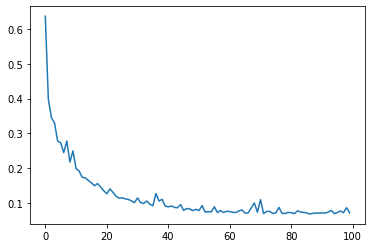

In [48]:
plt.plot(test_loss_lst)

**무엇을 보완하였고, 왜 보완되었는지에 대한 자유 서술 (아래에)**

leaky relu로 시도 ,  test loss 가 점점 커지는 경향성을 보임->learning rate 너무 빠른 것 같아 0.1로 시도